# Notebook for plotting pickle files

In [0]:
from __future__ import division, print_function, absolute_import
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.ticker import StrMethodFormatter
import torchvision
import torch.nn as nn
from math import ceil
import pickle 
from PIL import Image as PILImage

In [2]:
from google.colab import drive
drive.mount('gdrive/')
os.chdir('gdrive/My Drive/Colab Notebooks/FACT/')
# '/gdrive/My Drive/Colab Notebooks/NLP1/Practical 2/googlenews.word2vec.300d.txt'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive/


In [0]:
class Encoder(nn.Module):
    '''Encoder'''
    def __init__(self):
        super(Encoder, self).__init__()
        
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3
        
        # define layers
        self.enc_l1 = nn.Conv2d(n_input_channel, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l4 = nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def pad_image(self, img):
        ''' Takes an input image (batch) and pads according to Tensorflows SAME padding'''
        input_h = img.shape[2]
        input_w = img.shape[3]
        stride = 2 
        filter_h = 3
        filter_w = 3

        output_h = int(ceil(float(input_h)) / float(stride))
        output_w = output_h

        if input_h % stride == 0:
            pad_height = max((filter_h - stride), 0)
        else:
            pad_height = max((filter_h - (input_h % stride), 0))

        pad_width = pad_height

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_img = torch.zeros(img.shape[0], img.shape[1], input_h + pad_height, input_w + pad_width)
        padded_img[:,:, pad_top:-pad_bottom, pad_left:-pad_right] = img

        return padded_img
        
    def forward(self, x):
        pad_x = self.pad_image(x)
        el1 = self.relu(self.enc_l1(pad_x))
        
        pad_el1 = self.pad_image(el1)
        el2 = self.relu(self.enc_l2(pad_el1))
    
        pad_el2 = self.pad_image(el2)
        el3 = self.relu(self.enc_l3(pad_el2))
        
        pad_el3 = self.pad_image(el3)
        el4 = self.relu(self.enc_l4(pad_el3))
        
        return el4
        
class Decoder(nn.Module):
    '''Decoder'''
    def __init__(self):
        super(Decoder, self).__init__()
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3

        # define layers
        self.dec_l4 = nn.ConvTranspose2d(10, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l3 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=0) # the output padding here should be 1 if the images are 32x32
        self.dec_l2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l1 = nn.ConvTranspose2d(32, n_input_channel, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, enc_x):
        dl4 = self.relu(self.dec_l4(enc_x))
        dl3 = self.relu(self.dec_l3(dl4))
        dl2 = self.relu(self.dec_l2(dl3))
        decoded_x = self.sigmoid(self.dec_l1(dl2))
        
        return decoded_x


class nn_prototype(nn.Module):
    '''Model'''
    def __init__(self, n_prototypes=15, n_layers=4, n_classes=10):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # initialize prototype - currently not in correct spot
        
        # changed this for the colored mnist, from 40 to 160, the new shape would be 250*10*4*4
        n_features = 40 # size of encoded x - 250 x 10 x 2 x 2
        self.prototype_feature_vectors = nn.Parameter(torch.empty(size=(n_prototypes, n_features), 
                                                                  dtype=torch.float32).uniform_())
        
        self.last_layer = nn.Linear(n_prototypes,10)
        
    def list_of_distances(self, X, Y):
        '''
        Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
        Y = [y_1, ... , y_m], we return a list of vectors
                [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
                 ...
                 [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
        where the distance metric used is the sqared euclidean distance.
        The computation is achieved through a clever use of broadcasting.
        '''
        XX = torch.reshape(self.list_of_norms(X), shape=(-1, 1))
        YY = torch.reshape(self.list_of_norms(Y), shape=(1, -1))
        output = XX + YY - 2 * torch.mm(X, Y.t())

        return output

    def list_of_norms(self, X):
        '''
        X is a list of vectors X = [x_1, ..., x_n], we return
            [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
        function is the squared euclidean distance.
        '''
        return torch.sum(torch.pow(X, 2), dim=1)
    
    def forward(self, x):
        
        #print("Shape of input x", x.shape)
        
        #encoder step
        enc_x = self.encoder(x)
        
        #print("Shape of encoded x", enc_x.shape)
        
        #decoder step
        dec_x = self.decoder(enc_x)
        
        #print("shape of decoded x", dec_x.shape)
        
        # hardcoded input size (not needed, shape already correct)
        # dec_x = dec_x.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        
        # flatten encoded x to compute distance with prototypes
        n_features = enc_x.shape[1] * enc_x.shape[2] * enc_x.shape[3]
        feature_vectors_flat = torch.reshape(enc_x, shape=[-1, n_features])
        
        #print("Shape of flattened feature vectors", feature_vectors_flat.shape)
        
        # distance to prototype
        prototype_distances = self.list_of_distances(feature_vectors_flat, self.prototype_feature_vectors)
        
        # distance to feature vectors
        feature_vector_distances = self.list_of_distances(self.prototype_feature_vectors, feature_vectors_flat)
        
        # classification layer
        logits = self.last_layer(prototype_distances)
        
        # Softmax to prob dist not needed as cross entropy loss is used?
        
        return dec_x, logits, feature_vector_distances, prototype_distances
        

In [0]:
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)


In [0]:
lambdas_class = [20]
lambdas_ae = [1, 5, 10, 20]
# lambdas_ae = [1]
lambdas_1 = [1]
lambdas_2 = [1, 5, 10, 20]
# lambdas_2 = [1, 5]

for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
    #         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/train_accs.p', 'rb') as f:
                train_accs = pickle.load(f)

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            with open(metrics_folder + '/valid_accs.p', 'rb') as f:
                valid_accs = pickle.load(f)

            with open(metrics_folder + '/train_losses.p', 'rb') as f:
                train_losses = pickle.load(f)

            with open(metrics_folder + '/test_losses.p', 'rb') as f:
                test_losses = pickle.load(f)
                # test_losses = torch.load(f, map_location=torch.device('cpu'))

            with open(metrics_folder + '/valid_losses.p', 'rb') as f:
                valid_losses = pickle.load(f)

            plots_folder = os.path.join(model_folder, "plots")
            makedirs(plots_folder)

            t_epochs = list(range(0, len(train_accs)))
            print(len(t_epochs))
            t_epochs = [x / 220 for x in t_epochs]
            v_epochs = list(range(0, len(valid_accs)))
            test_epochs = list(range(0, len(valid_accs), 5))

            plt.rcParams.update({'font.size': 15})
            
            # figsize
            plt.figure(figsize=(15, 12))

            # plot metrics
            plt.plot(t_epochs, train_accs, label="Training accuracy", alpha = 0.5)
            plt.plot(v_epochs, valid_accs, label="Valid accuracy")
            plt.plot(test_epochs, test_accs, label="Test accuracy")

            # plot highest test score
            plt.plot([min(t_epochs), max(t_epochs)], [max(test_accs)]*2, alpha = 0.8, linestyle='--', color='black', label='Highest test acc')

            # add legend
            plt.legend()

            # yticks and formatting
            plt.yticks([0.2, 0.4, 0.6, 0.8, max(test_accs), 1])
            plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
            plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

            plt.savefig(plots_folder + '/accs.png')

            plt.close()

            ########## LOSSES

            plt.figure(figsize=(15, 12))
            plt.plot(t_epochs, train_losses, label="Training loss", alpha=0.5)
            plt.plot(v_epochs, valid_losses, label="Valid loss")
            plt.plot(test_epochs, test_losses, label="Test loss")
            plt.legend()
            plt.savefig(plots_folder + '/losses.png')
            # plt.show()

            plt.close()

KeyboardInterrupt: ignored

In [0]:
lambdas_class = [20]
lambdas_ae = [1, 5, 10, 20, 40]
# lambdas_ae = [1]
lambdas_1 = [1]
lambdas_2 = [1, 5, 10, 20, 40]
# lambdas_2 = [1, 5]

max_acc = 0
for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
    #         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/train_accs.p', 'rb') as f:
                train_accs = pickle.load(f)

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            with open(metrics_folder + '/valid_accs.p', 'rb') as f:
                valid_accs = pickle.load(f)

            with open(metrics_folder + '/train_losses.p', 'rb') as f:
                train_losses = pickle.load(f)

            with open(metrics_folder + '/test_losses.p', 'rb') as f:
                test_losses = pickle.load(f)
                # test_losses = torch.load(f, map_location=torch.device('cpu'))

            with open(metrics_folder + '/valid_losses.p', 'rb') as f:
                valid_losses = pickle.load(f)

            curr_max = max(test_accs)
            if curr_max > max_acc:
                print('New highscore: ', curr_max)
                print('Lambdas: ', lambda_class, lambda_ae, lambda_1, lambda_2)

                max_acc = curr_max




New highscore:  0.899
Lambdas:  20 1 1 1
New highscore:  0.9124
Lambdas:  20 1 1 5
New highscore:  0.917
Lambdas:  20 5 1 1
New highscore:  0.9183
Lambdas:  20 10 1 1


# Table for maximum scores per lambda

In [0]:
lambdas_class = [20]
lambdas_ae = [1, 5, 10, 20, 40]
# lambdas_ae = [1]
lambdas_1 = [1]
lambdas_2 = [1, 5, 10, 20, 40]
# lambdas_2 = [1, 5]

max_acc = 0
for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
    #         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/train_accs.p', 'rb') as f:
                train_accs = pickle.load(f)

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            with open(metrics_folder + '/valid_accs.p', 'rb') as f:
                valid_accs = pickle.load(f)

            with open(metrics_folder + '/train_losses.p', 'rb') as f:
                train_losses = pickle.load(f)

            with open(metrics_folder + '/test_losses.p', 'rb') as f:
                test_losses = pickle.load(f)
                # test_losses = torch.load(f, map_location=torch.device('cpu'))

            with open(metrics_folder + '/valid_losses.p', 'rb') as f:
                valid_losses = pickle.load(f)

            score = round(max(test_accs),3)
            # tif score > 0.905:
            print(f"{lambda_class} & {lambda_ae} & {lambda_1} & {lambda_2} & {score} \\\\")

20 & 1 & 1 & 5 & 0.912 \\
20 & 1 & 1 & 10 & 0.908 \\
20 & 5 & 1 & 1 & 0.917 \\
20 & 5 & 1 & 5 & 0.916 \\
20 & 10 & 1 & 1 & 0.918 \\
20 & 20 & 1 & 5 & 0.915 \\


# original model metrics 

6820


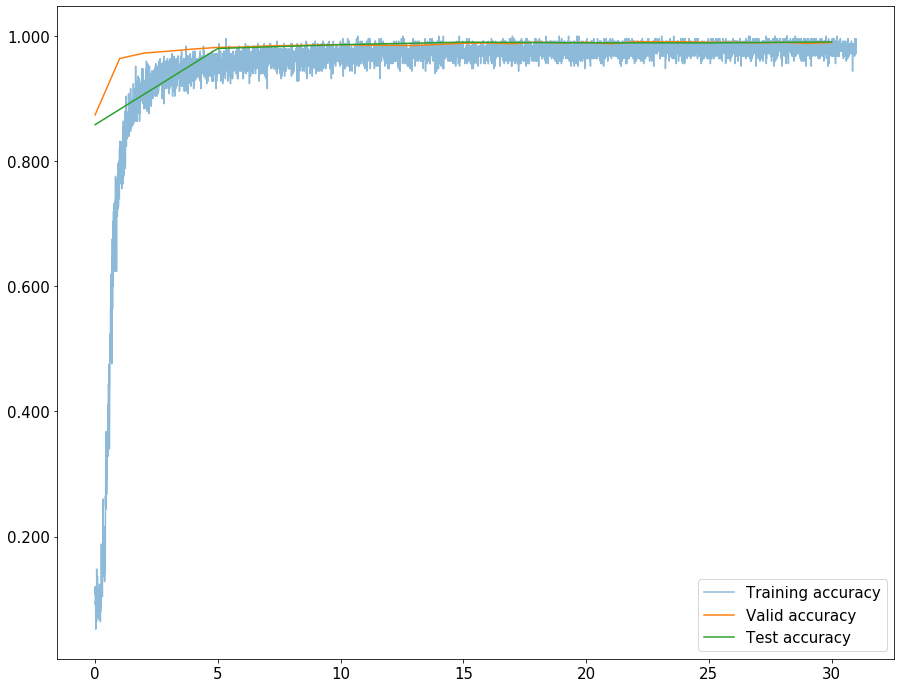

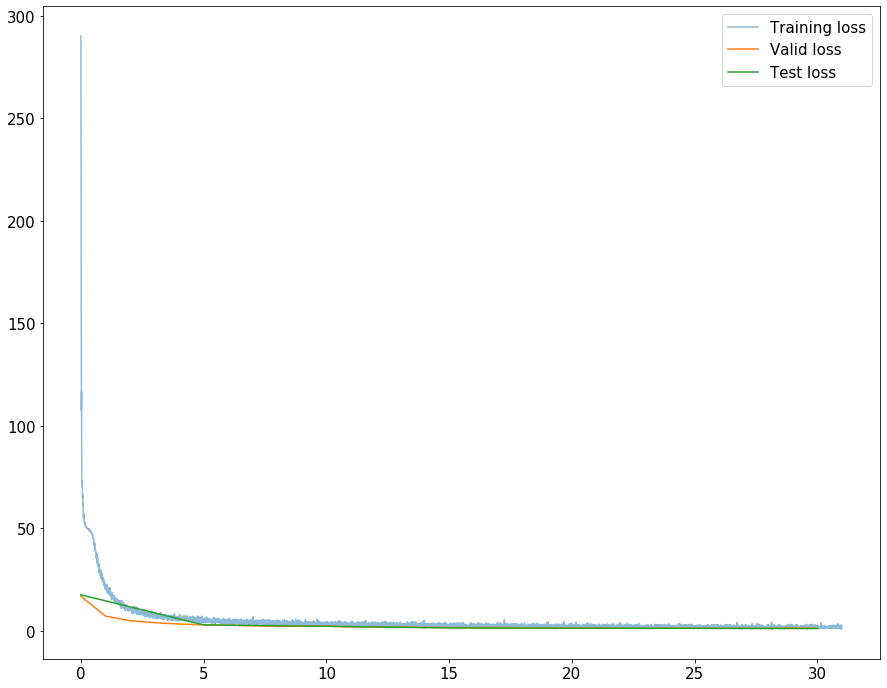

0.991


In [0]:


max_acc = 0

train_accs = []
test_accs = []
valid_accs = []
train_losses = []
test_losses = []
valid_losses = []

model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model")
#         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

metrics_folder = os.path.join(model_folder, "metrics")

with open(metrics_folder + '/train_accs.p', 'rb') as f:
    train_accs = pickle.load(f)

with open(metrics_folder + '/test_accs.p', 'rb') as f:
    test_accs = pickle.load(f)

with open(metrics_folder + '/valid_accs.p', 'rb') as f:
    valid_accs = pickle.load(f)

with open(metrics_folder + '/train_losses.p', 'rb') as f:
    train_losses = pickle.load(f)

with open(metrics_folder + '/test_losses.p', 'rb') as f:
    test_losses = pickle.load(f)
    # test_losses = torch.load(f, map_location=torch.device('cpu'))

with open(metrics_folder + '/valid_losses.p', 'rb') as f:
    valid_losses = pickle.load(f)

score = round(max(test_accs),3)

plots_folder = os.path.join(model_folder, "plots")
makedirs(plots_folder)

t_epochs = list(range(0, len(train_accs)))
print(len(t_epochs))
t_epochs = [x / 220 for x in t_epochs]
v_epochs = list(range(0, len(valid_accs)))
test_epochs = list(range(0, len(valid_accs), 5))

plt.rcParams.update({'font.size': 15})

# figsize
plt.figure(figsize=(15, 12))

# plot metrics
plt.plot(t_epochs, train_accs, label="Training accuracy", alpha = 0.5)
plt.plot(v_epochs, valid_accs, label="Valid accuracy")
plt.plot(test_epochs, test_accs, label="Test accuracy")

# plot highest test score
# plt.plot([min(t_epochs), max(t_epochs)], [max(test_accs)]*2, alpha = 0.8, linestyle='--', color='black', label='Highest test acc')

# add legend
plt.legend()

# yticks and formatting
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

# plt.savefig(plots_folder + '/accs.png')
plt.show()
plt.close()

########## LOSSES

plt.figure(figsize=(15, 12))
plt.plot(t_epochs, train_losses, label="Training loss", alpha=0.5)
plt.plot(v_epochs, valid_losses, label="Valid loss")
plt.plot(test_epochs, test_losses, label="Test loss")
plt.legend()
# plt.savefig(plots_folder + '/losses.png')
plt.show()

plt.close()
print(score)

# CIFAR plots

In [0]:


max_acc = 0

train_accs = []
test_accs = []
valid_accs = []
train_losses = []
test_losses = []
valid_losses = []

model_folder = os.path.join(os.getcwd(), "saved_model", "cifar_model")
#         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

metrics_folder = os.path.join(model_folder, "metrics")

with open(metrics_folder + '/train_accs.p', 'rb') as f:
    train_accs = pickle.load(f)

with open(metrics_folder + '/test_accs.p', 'rb') as f:
    test_accs = pickle.load(f)

with open(metrics_folder + '/valid_accs.p', 'rb') as f:
    valid_accs = pickle.load(f)

with open(metrics_folder + '/train_losses.p', 'rb') as f:
    train_losses = pickle.load(f)

with open(metrics_folder + '/test_losses.p', 'rb') as f:
    test_losses = pickle.load(f)
    # test_losses = torch.load(f, map_location=torch.device('cpu'))

with open(metrics_folder + '/valid_losses.p', 'rb') as f:
    valid_losses = pickle.load(f)

score = round(max(test_accs),3)

plots_folder = os.path.join(model_folder, "plots")
makedirs(plots_folder)

t_epochs = list(range(0, len(train_accs)))
print(len(t_epochs))
t_epochs = [x / 180 for x in t_epochs]
v_epochs = list(range(0, len(valid_accs)))
test_epochs = list(range(0, len(valid_accs), 5))

plt.rcParams.update({'font.size': 15})

# figsize
plt.figure(figsize=(15, 12))

# plot metrics
plt.plot(t_epochs, train_accs, label="Training accuracy", alpha = 0.5)
plt.plot(v_epochs, valid_accs, label="Valid accuracy")
plt.plot(test_epochs, test_accs, label="Test accuracy")

# plot highest test score
# plt.plot([min(t_epochs), max(t_epochs)], [max(test_accs)]*2, alpha = 0.8, linestyle='--', color='black', label='Highest test acc')

# add legend
plt.legend()

# yticks and formatting
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.savefig(plots_folder + '/accs.png')
# plt.show()
plt.close()

########## LOSSES

plt.figure(figsize=(15, 12))
plt.plot(t_epochs, train_losses, label="Training loss", alpha=0.5)
plt.plot(v_epochs, valid_losses, label="Valid loss")
plt.plot(test_epochs, test_losses, label="Test loss")
plt.legend()
plt.savefig(plots_folder + '/losses.png')
# plt.show()
plt.close()
print(len(train_accs))

5580
5580


# Grayscale accs

In [14]:
lambdas_class = [20]
lambdas_ae = [1, 5, 10, 20]
lambdas_ae = [1]
lambdas_1 = [1]
lambdas_2 = [1, 5, 10, 20]
# lambdas_2 = [1]

max_acc = 0
for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "gray_mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
    #         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/train_accs.p', 'rb') as f:
                train_accs = pickle.load(f)

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            with open(metrics_folder + '/valid_accs.p', 'rb') as f:
                valid_accs = pickle.load(f)

            with open(metrics_folder + '/train_losses.p', 'rb') as f:
                train_losses = pickle.load(f)

            with open(metrics_folder + '/test_losses.p', 'rb') as f:
                test_losses = pickle.load(f)
                # test_losses = torch.load(f, map_location=torch.device('cpu'))

            with open(metrics_folder + '/valid_losses.p', 'rb') as f:
                valid_losses = pickle.load(f)

            # curr_max = max(test_accs)
            # if curr_max > max_acc:
            #     print('New highscore: ', curr_max)
            #     print('Lambdas: ', lambda_class, lambda_ae, lambda_1, lambda_2)
            # print(test_accs)
            #     max_acc = curr_max
            score = round(max(test_accs),3)
            max_epoch = np.argmax(test_accs)
            # if score > 0.905:
            print(f"{lambda_class} & {lambda_ae} & {lambda_1} & {lambda_2} & {score} & Epoch: {max_epoch * 5} \\\\")

20 & 1 & 1 & 1 & 0.98 & Epoch: 25 \\
20 & 1 & 1 & 5 & 0.977 & Epoch: 25 \\
20 & 1 & 1 & 10 & 0.976 & Epoch: 25 \\
20 & 1 & 1 & 20 & 0.975 & Epoch: 30 \\


# MNIST color accs

In [8]:
lambdas_class = [20]
# lambdas_ae = [1, 5, 10, 20]
lambdas_ae = [1]
lambdas_1 = [1]
lambdas_2 = [1, 5, 10, 20]
# lambdas_2 = [1, 5]

max_acc = 0
for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
    #         model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/train_accs.p', 'rb') as f:
                train_accs = pickle.load(f)

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            with open(metrics_folder + '/valid_accs.p', 'rb') as f:
                valid_accs = pickle.load(f)

            with open(metrics_folder + '/train_losses.p', 'rb') as f:
                train_losses = pickle.load(f)

            with open(metrics_folder + '/test_losses.p', 'rb') as f:
                test_losses = pickle.load(f)
                # test_losses = torch.load(f, map_location=torch.device('cpu'))

            with open(metrics_folder + '/valid_losses.p', 'rb') as f:
                valid_losses = pickle.load(f)

            # curr_max = max(test_accs)
            # if curr_max > max_acc:
            #     print('New highscore: ', curr_max)
            #     print('Lambdas: ', lambda_class, lambda_ae, lambda_1, lambda_2)

            #     max_acc = curr_max
            score = round(max(test_accs),3)
            max_epoch = np.argmax(test_accs)
            # if score > 0.905:
            print(f"{lambda_class} & {lambda_ae} & {lambda_1} & {lambda_2} & {score} & Epoch: {max_epoch * 5} \\\\")




KeyboardInterrupt: ignored

# Reporting test results per trained model

In [11]:
lambdas_class = [20]
# lambdas_ae = [1, 5, 10, 20]
lambdas_ae = [1]
lambdas_1 = [1]
# lambdas_2 = [1, 5, 10, 20]
lambdas_2 = [1]

max_acc = 0
for i in range(len(lambdas_class)):
    lambda_class = lambdas_class[i]
    for j in range(len(lambdas_ae)):
        lambda_ae = lambdas_ae[j]
        for k in range(len(lambdas_2)):
            lambda_1 = 1
            lambda_2 = lambdas_2[k]

            train_accs = []
            test_accs = []
            valid_accs = []
            train_losses = []
            test_losses = []
            valid_losses = []

            model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2))
            model_filename = "mnist_cae_color28_" + str(lambda_class) + '_' + str(lambda_ae) + '_' + str(lambda_1) + '_' + str(lambda_2)

            metrics_folder = os.path.join(model_folder, "metrics")

            with open(metrics_folder + '/test_accs.p', 'rb') as f:
                test_accs = pickle.load(f)

            score = round(max(test_accs),3)
            max_epoch = np.argmax(test_accs)
            
            loaded_model = torch.load(model_folder + "/" + model_filename + '_epoch_' + str(max_epoch * 5) + '.pt')

            print(f"Saved score: {score}, at epoch: {max_epoch * 5}")
            





Saved score: 0.951, at epoch: 30


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type nn_prototype. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
